# Training the model to run on Lichess data
## Some pre-requisites if running on Google Collab
If not running on Google collab do not run these next two cells!

In [1]:
# Install the only dependency not available from collab directly
!pip install chess

# Get imported files from repo
!git clone -b lichess-neural-networks https://github.com/owenjaques/chessbot.git
!mv chessbot chessbot-repo
!mv chessbot-repo/neural_networks/chessbot .
!rm chessbot-repo -r

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 KB 4.5 MB/s eta 0:00:00
Cloning into 'chessbot'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 424 (delta 103), reused 167 (delta 60), pack-reused 203
Receiving objects: 100% (424/424), 33.71 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
working_directory = '/content/gdrive/MyDrive/chessbot_weights/'
print(f'Saving to {working_directory}')

Mounted at /content/gdrive
Saving to /content/gdrive/MyDrive/chessbot_weights/


## If not running on Google Collab
Set the weights directory variable to wherever you would like data saved.

In [ ]:
!mkdir -p data
working_directory = './data/'

## Get the data
This compression format is really nice, so you can cancel this cell whenever you want and all the games that were downloaded will be maintained. In my experience 300Mb gets well over 100,000 games.

In [3]:
!wget https://database.lichess.org/standard/lichess_db_standard_rated_2023-02.pgn.zst

--2023-03-19 23:07:55--  https://database.lichess.org/standard/lichess_db_standard_rated_2023-02.pgn.zst
Resolving database.lichess.org (database.lichess.org)... 141.95.66.62, 2001:41d0:700:5e3e::
Connecting to database.lichess.org (database.lichess.org)|141.95.66.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31838284336 (30G) [application/octet-stream]
Saving to: ‘lichess_db_standard_rated_2023-02.pgn.zst’

2023-02.pgn.zst       3%[                    ]   1.03G  16.6MB/s    eta 31m 0s ^C


## Decompress the Data

In [4]:
!apt install zstd
!pzstd -d lichess_db_standard_rated_2023-02.pgn.zst

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,592 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 zstd amd64 1.4.4+dfsg-3ubuntu0.1 [343 kB]
Fetched 343 kB in 1s (359 kB/s)
Selecting previously unselected package zstd.
(Reading database ... 128276 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.4+dfsg-3ubuntu0.1_amd64.deb ...
Unpacking zstd (1.4.4+dfsg-3ubuntu0.1) ...
Setting up zstd (1.4.4+dfsg-3ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
pzstd: lichess_db_standard_rated_2023-02.pgn.zst: Incomplete block.


## Transform the Data
For this section we create a data generator which will play the games from disk then translate them into labelled model inputs which the model will train on.

In [3]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [4]:
from chessbot.model_input import ModelInput
from sklearn.utils import shuffle
from os.path import exists

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, pgn_file, num_batches=128, name='training_data', label_for='regression', verbose=0, regenerate_each_epoch=True, save_directory=None):
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.pgn = pgn_file
        self.n = batch_size * num_batches
        self.verbose = verbose
        self.name = name
        self.label_for = label_for
        self.regenerate_each_epoch = regenerate_each_epoch
        self.epoch = 1
        self.save_directory = save_directory

        self.X = np.empty((self.n, 102))
        self.y = np.empty((self.n, 3), dtype=int) if self.label_for == 'classification' else np.empty(self.n)

        self.populate_Xy()

    def populate_Xy(self):
        # Plays games from the dataset and populates X and y

        if self.save_directory != None:
            filename = f'{self.save_directory}epoch{int(self.epoch)}_{self.name}.npz'
            if exists(filename):
                data = np.load(filename)
                self.X = data['X']
                self.y = data['y']
                
                if self.verbose > 0:
                    print(f'Loaded {len(self.X)} samples.')

                return

        # Used to make sure the data in X and y is uniform
        n_bins = 16
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bins = np.zeros(n_bins, dtype=int)
        
        i = 0
        while i < self.n:
            game = chess.pgn.read_game(self.pgn)
            if game is None:
                raise Exception('DataGenerator: Out of data to read from disk.')
    
            # Only train on game played to completion, that were not draws, and that have evaluations
            next_node = game.next()
            if not (game.headers['Termination'] == 'Normal' and game.headers['Result'] in ['1-0', '0-1'] and next_node and next_node.eval() != None):
                continue

            try:
                # Generate the data from the game
                board = game.board()
                for node in game.mainline():
                    board.push(node.move)
                    eval = node.eval().white().score(mate_score=10000)

                    if self.label_for == 'classification':
                        self.X[i] = ModelInput(board).get_input()
                        y[i] = [eval <= -125, -125 < eval < 125, eval >= 125]
                        i += 1
                    else:
                        # Threshold to remove outliers and increase distribution of data
                        threshold_boundary = 1500
                        y = threshold_boundary if eval > threshold_boundary else -threshold_boundary if eval < -threshold_boundary else eval

                        # Normalise in the range [0, 1]
                        y = (y + threshold_boundary) / (2 * threshold_boundary)

                        # Don't keep this sample if we have already collected enough samples in its bin
                        bin = np.digitize(y, bin_boundaries) - 1
                        if bins[bin] < self.n / n_bins:
                            self.X[i] = ModelInput(board).get_input()
                            self.y[i] = y
                            bins[bin] += 1
                            i += 1
                    
                    if self.verbose > 0:
                        print(f'\rGenerated {i}/{self.n} samples for {self.name}', end='')
            except:
                # There are a lot of reasons an exception could be thrown here, mostly stemming from bad data being parsed
                # from the pgn file. We just ignore these games and move on.
                pass

        # Shuffle X and y so batches of data are a bit more normal
        self.X, self.y = shuffle(self.X, self.y)

        if self.verbose > 0 and self.label_for == 'classification':
            print(f'\nData generator for {self.name}: Number of losing positions: {np.sum(self.y[:, 0])}, Number of drawing positions: {np.sum(self.y[:, 1])}, Number of winning positions: {np.sum(self.y[:, 2])}')
        
        if self.label_for == 'regression' and self.verbose > 1:
            _, ax = plt.subplots(figsize=(6, 6))
            ax.hist(self.y, bins=n_bins)
            ax.set_title(f'Labels for {self.name}')
            ax.set_xlabel('label (y)')
            ax.set_ylabel('no. of occurences in dataset')
            plt.show()

        # Save the data to a file so its quicker to train next time
        np.savez_compressed(f'{self.save_directory}epoch{int(self.epoch)}_{self.name}.npz', X=self.X, y=self.y)
        
    def on_epoch_end(self):
        self.epoch += 1

        if self.regenerate_each_epoch:
            self.populate_Xy()

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # Returns one batch of data
        batch_idx_start = idx * self.batch_size
        batch_idx_end = idx * (self.batch_size + 1)
        return self.X[batch_idx_start:batch_idx_end], self.y[batch_idx_start:batch_idx_end]

### Get X and y from all the files we've saved
This allows us to create one big set of data to train the model on instead of using several small sets.

In [7]:
X = None
y = None

for epoch in range(1, 13):
    data = np.load(f'{working_directory}epoch{epoch}_training_data.npz')
    
    if epoch == 1:
        X = data['X']
        y = data['y']
    else:
        X = np.concatenate([X, data['X']])
        y = np.concatenate([y, data['y']])

data = np.load(f'{working_directory}epoch1_validation_data.npz')
validation_data = (data['X'], data['y'])

print(X.shape, y.shape)

(196608, 102) (196608,)


## Our Model
Set up your model being used here.

### Classification Model

In [ ]:
model = keras.Sequential([
	keras.layers.Dense(512, activation='relu'),
	keras.layers.Dense(512, activation='relu'),
	keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
	metrics=['accuracy']
)

### Regression Model

In [8]:
model = keras.Sequential([
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
	#optimizer=keras.optimizers.SGD(learning_rate=0.001, nesterov=True, momentum=0.7),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

## Training the model

In [10]:
pgn_file = open('lichess_db_standard_rated_2023-02.pgn', 'r')
batch_size = 32
num_batches = 512

training_data = DataGenerator(batch_size, pgn_file, num_batches, verbose=1, save_directory=working_directory)
validation_data = DataGenerator(batch_size, pgn_file, int(num_batches*0.2), name='validation_data', verbose=1, regenerate_each_epoch=False, save_directory=working_directory)

Loaded 16384 samples.
Loaded 3264 samples.


In [55]:
print(int(np.sum(np.isnan(training_data.X.flatten()))))
print(f'{working_directory}logs')

0
/content/gdrive/MyDrive/chessbot_weights/logs


In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=5,
    verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=0.00000000000001,
    verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint(
    f'{working_directory}lichess_trained_model',
    monitor='val_loss',
    save_best_only=True)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=f'{working_directory}logs',
    write_graph=True,
    write_images=True,
    histogram_freq=1)

model.fit(
    X,
    y,
    epochs=128,
    validation_data=validation_data,
    shuffle=True,
    callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard])

Epoch 1/128
6144/6144 [==============================] - ETA: 0s - loss: 0.0567 - mean_absolute_error: 0.1837

6144/6144 [==============================] - 28s 3ms/step - loss: 0.0567 - mean_absolute_error: 0.1837 - val_loss: 0.0522 - val_mean_absolute_error: 0.1801 - lr: 0.0010
Epoch 2/128
6130/6144 [============================>.] - ETA: 0s - loss: 0.0496 - mean_absolute_error: 0.1700
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6144/6144 [==============================] - 19s 3ms/step - loss: 0.0496 - mean_absolute_error: 0.1700 - val_loss: 0.0525 - val_mean_absolute_error: 0.1753 - lr: 0.0010
Epoch 3/128
6141/6144 [============================>.] - ETA: 0s - loss: 0.0449 - mean_absolute_error: 0.1585

6144/6144 [==============================] - 20s 3ms/step - loss: 0.0449 - mean_absolute_error: 0.1585 - val_loss: 0.0483 - val_mean_absolute_error: 0.1668 - lr: 2.0000e-04
Epoch 4/128
6129/6144 [============================>.] - ETA: 0s - loss: 0.0435 - mean_absolute_error: 0.1551

6144/6144 [==============================] - 20s 3ms/step - loss: 0.0435 - mean_absolute_error: 0.1551 - val_loss: 0.0475 - val_mean_absolute_error: 0.1627 - lr: 2.0000e-04
Epoch 5/128
6137/6144 [============================>.] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.1525
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
6144/6144 [==============================] - 20s 3ms/step - loss: 0.0424 - mean_absolute_error: 0.1525 - val_loss: 0.0476 - val_mean_absolute_error: 0.1616 - lr: 2.0000e-04
Epoch 6/128
6130/6144 [============================>.] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.1480

6144/6144 [==============================] - 20s 3ms/step - loss: 0.0405 - mean_absolute_error: 0.1480 - val_loss: 0.0465 - val_mean_absolute_error: 0.1607 - lr: 4.0000e-05
Epoch 7/128
6126/6144 [============================>.] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.1470

6144/6144 [==============================] - 21s 3ms/step - loss: 0.0401 - mean_absolute_error: 0.1470 - val_loss: 0.0460 - val_mean_absolute_error: 0.1596 - lr: 4.0000e-05
Epoch 8/128
6136/6144 [============================>.] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.1462
Epoch 8: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
6144/6144 [==============================] - 19s 3ms/step - loss: 0.0397 - mean_absolute_error: 0.1462 - val_loss: 0.0461 - val_mean_absolute_error: 0.1600 - lr: 4.0000e-05
Epoch 9/128
6144/6144 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.1450
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
6144/6144 [==============================] - 20s 3ms/step - loss: 0.0392 - mean_absolute_error: 0.1450 - val_loss: 0.0462 - val_mean_absolute_error: 0.1597 - lr: 8.0000e-06
Epoch 10/128
6140/6144 [============================>.] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.14

6144/6144 [==============================] - 19s 3ms/step - loss: 0.0391 - mean_absolute_error: 0.1448 - val_loss: 0.0460 - val_mean_absolute_error: 0.1591 - lr: 1.6000e-06
Epoch 11/128
6137/6144 [============================>.] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.1447
Epoch 11: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
6144/6144 [==============================] - 19s 3ms/step - loss: 0.0391 - mean_absolute_error: 0.1447 - val_loss: 0.0460 - val_mean_absolute_error: 0.1591 - lr: 3.2000e-07
Epoch 12/128
6133/6144 [============================>.] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.1447
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
6144/6144 [==============================] - 19s 3ms/step - loss: 0.0390 - mean_absolute_error: 0.1447 - val_loss: 0.0460 - val_mean_absolute_error: 0.1591 - lr: 6.4000e-08
Epoch 13/128
6135/6144 [============================>.] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 

### Launch tensorboard

In [ ]:
%reload_ext tensorboard
!kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
%tensorboard --logdir /content/gdrive/MyDrive/chessbot_weights/logs/

### Optionally load a previous model

In [ ]:
model = keras.models.load_model(f'{working_directory}/lichess_trained_model')

### Confusion Matrix

204/204 [==============================] - 0s 1ms/step


[Text(0.5, 15.0, 'Predicted label'), Text(33.0, 0.5, 'True label')]

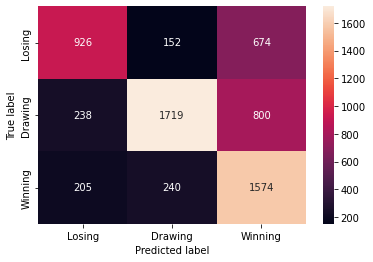

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(validation_data.X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(validation_data.y, axis=1)
cm = confusion_matrix(y_true, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Losing', 'Drawing', 'Winning'], yticklabels=['Losing', 'Drawing', 'Winning'])
ax.set(xlabel='Predicted label', ylabel='True label')

### Evaluate model

102/102 [==============================] - 0s 2ms/step


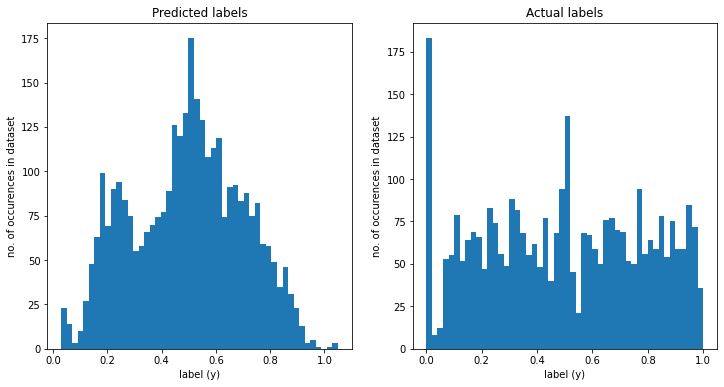

[Text(0.5, 15.0, 'Predicted label'), Text(33.0, 0.5, 'True label')]

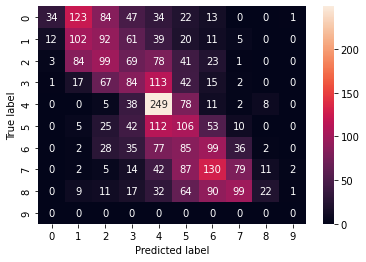

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Since at the end of the epoch the validation data is refreshed,
# validation_data actually holds new data at the end of training
evaluation = model.evaluate(validation_data)
predictions = model.predict(validation_data[0])

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].hist(predictions, bins=50)
ax[0].set_title(f'Predicted labels')
ax[0].set_xlabel('label (y)')
ax[0].set_ylabel('no. of occurences in dataset')
ax[1].hist(validation_data[1], bins=50)
ax[1].set_title(f'Actual labels')
ax[1].set_xlabel('label (y)')
ax[1].set_ylabel('no. of occurences in dataset')
plt.show()

# Bin the data into continuous intervals, then plot a confusion matrix
predictions_binned = np.digitize(predictions, bins=np.linspace(0, 1, 10))
y_binned = np.digitize(validation_data[1], bins=np.linspace(0, 1, 10))
cm = confusion_matrix(y_binned, predictions_binned)
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set(xlabel='Predicted label', ylabel='True label')

## Why not play a game after all that training?

In [ ]:
import time
from IPython.display import clear_output
import chessbot.chessbot
import importlib
importlib.reload(chessbot.chessbot)
from chessbot.chessbot import ChessBot

def play_game(model, exploration_rate=0.0, should_visualise=False):
	white = ChessBot(model, chess.WHITE, exploration_rate)
	black = ChessBot(model, chess.BLACK, exploration_rate)

	board = chess.Board()

	if should_visualise:
		display(board)
  
	#chess.Move.from_uci(input())

	while not board.is_game_over(claim_draw=True):
		board.push(black.move(board) if board.turn == chess.BLACK else chess.Move.from_uci(input()))

		if should_visualise:
			time.sleep(1)
			clear_output(wait=True)
			display(board)

	return board.outcome(claim_draw=True).result()
 
play_game(model, should_visualise=True)